<a href="https://colab.research.google.com/github/shashwatrathod/InfosysStockPricePrediction/blob/master/InfosysStockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Stock Prices of Infosys

In [0]:
import pandas_datareader as web
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import CuDNNLSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import pickle
import time

plt.style.use('fivethirtyeight')

BUFFER is the number of past closing prices used to predict the next closing price.
I experimented with various epochs and buffer size but found this to be working best.

In [0]:
BUFFER = 90
LEARNING_RATE = 0.001
EPOCHS = 4

In [0]:
today = datetime.today().strftime('%d-%m-%y')
df = web.DataReader('INFY',data_source='yahoo',start='20-02-2005', end=today)
print(df.tail())

             High    Low   Open  Close      Volume  Adj Close
Date                                                         
2020-02-14  11.12  11.01  11.08  11.01   5420300.0      11.01
2020-02-18  11.27  11.14  11.15  11.21   8421200.0      11.21
2020-02-19  11.34  11.22  11.24  11.30   7540600.0      11.30
2020-02-20  11.38  11.19  11.22  11.36  11640000.0      11.36
2020-02-21  11.44  11.30  11.33  11.41  10524200.0      11.41


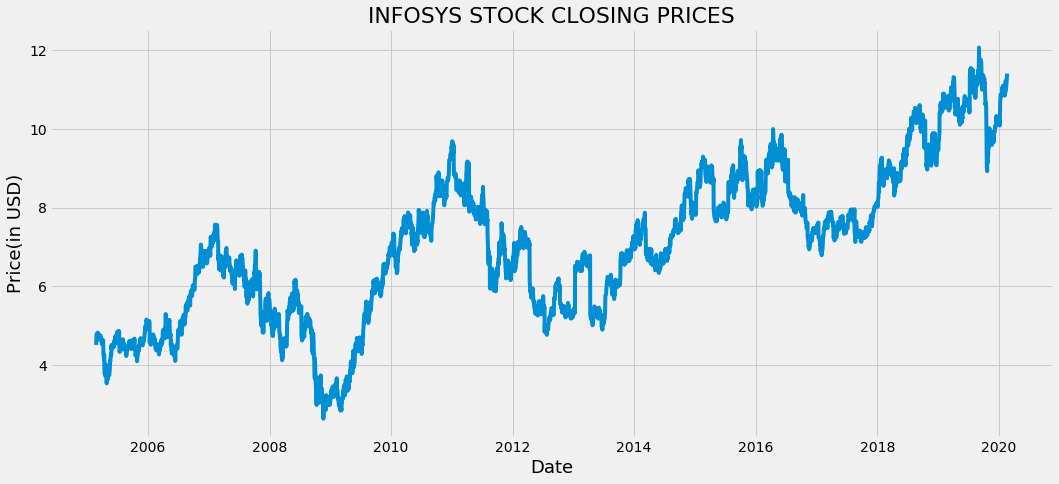

In [0]:
closing_data = df['Close']
plt.figure(1,figsize=(16,7))
plt.plot(closing_data)
plt.title('INFOSYS STOCK CLOSING PRICES', fontsize=22)
plt.ylabel('Price(in USD)', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.show()

## Test-Train Split

In [0]:
c_data = closing_data.to_numpy()
train_split_ratio = 0.8
train_index = int(np.ceil(closing_data.shape[0]*train_split_ratio))
print(train_index)
training_data = c_data[:train_index]
test_data = c_data[train_index:]
print(f"Training data shape: {training_data.shape}")
print(f"Test data shape: {test_data.shape}")

3021
Training data shape: (3021,)
Test data shape: (755,)


## Normalization

In [0]:
def fit_transform(X):
  norm_factors=[]
  if(len(X.shape)==1):
    norm_factors.append(np.max(X))
    X = X/np.max(X)
  else:
    for col in range(X.shape[1]):
      norm_factors.append(np.max(X[:,col]))
      X[:,col] = X[:,col]/np.max(X[:,col])
  
  with open("normalization_factors.pkl","wb") as f:
    pickle.dump(norm_factors,f)
  
  X = np.asarray(X)
  return X,norm_factors

def inverse_transform(X):
  with open("normalization_factors.pkl","rb") as f:
    norm_factors = pickle.load(f)
  
  X = X*norm_factors
  return X

def transform(X):
  with open("normalization_factors.pkl","rb") as f:
    norm_factors = pickle.load(f)
  
  return X/norm_factors

training_data_scaled,norm_factors = fit_transform(training_data)
print(training_data_scaled)
print(training_data_scaled.shape)

[0.45149999 0.45587502 0.46125002 ... 0.74949999 0.74400001 0.7645    ]
(3021,)


## X-y split

In [0]:
def X_y_split(data, buffer):
  X = []
  y = []
  for i in range(buffer,data.shape[0]):
    X.append(data[i-buffer:i])
    y.append(data[i])
  
  return np.asarray(X),np.asarray(y)

train_x,train_y = X_y_split(training_data_scaled,BUFFER)
print(train_x[:2])
print(train_y[:2])

test_data_scaled = transform(test_data)
test_x,test_y = X_y_split(test_data_scaled,BUFFER)
print(test_x[:2])
print(test_y[:2])

[[0.45149999 0.45587502 0.46125002 0.47874999 0.4765625  0.47593751
  0.46937499 0.47756252 0.48262501 0.48181248 0.47862501 0.4671875
  0.47350001 0.46500001 0.46687498 0.46656251 0.47318749 0.47224998
  0.47249999 0.47575002 0.47193751 0.46668749 0.46887498 0.4663125
  0.45368748 0.45625    0.46081252 0.46125002 0.4598125  0.46187501
  0.46374998 0.44406252 0.42662501 0.41500001 0.42668748 0.4131875
  0.3846875  0.37787499 0.38231249 0.37606249 0.371875   0.3903125
  0.40212498 0.38499999 0.36400001 0.35374999 0.35925    0.37
  0.36512499 0.36256249 0.3721875  0.38243749 0.39124999 0.39449999
  0.392875   0.384375   0.37393751 0.37693751 0.39268751 0.39625001
  0.41143751 0.41018748 0.41468749 0.4296875  0.42531252 0.4296875
  0.450875   0.440625   0.45212498 0.44518752 0.44274998 0.44475002
  0.45012498 0.45124998 0.448875   0.4524375  0.44656248 0.4605
  0.4578125  0.46556249 0.4589375  0.47224998 0.47462502 0.46875
  0.47325001 0.46062498 0.45593748 0.46218748 0.47175002 0.4838749

## Creating the model

In [0]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

model = Sequential()
model.add(CuDNNLSTM(units=BUFFER,input_shape=(train_x.shape[1],1),return_sequences=True))
model.add(CuDNNLSTM(units=BUFFER,input_shape=(train_x.shape[1],1),return_sequences=False))
model.add(Dense(units=BUFFER-20,activation='relu'))
model.add(Dense(units=1,activation='relu'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['accuracy'])

name = f"STOCKPRED-{int(time.time())}"
tensorboard = TensorBoard(log_dir=f"logs/{name}")
print(train_x.shape)
print(test_x.shape)

(2931, 90, 1)
(665, 90, 1)


## Training

In [0]:
model.fit(train_x, train_y,
          batch_size=1,
          epochs=EPOCHS,
          callbacks=[tensorboard],
          validation_data=(test_x,test_y))


Train on 2931 samples, validate on 665 samples
Epoch 1/4
2931/2931 [==============================] - 21s 7ms/sample - loss: 0.0020 - acc: 3.4118e-04 - val_loss: 7.9250e-04 - val_acc: 0.0015
Epoch 2/4
2931/2931 [==============================] - 20s 7ms/sample - loss: 6.0881e-04 - acc: 3.4118e-04 - val_loss: 7.7651e-04 - val_acc: 0.0015
Epoch 3/4
2931/2931 [==============================] - 19s 7ms/sample - loss: 4.7102e-04 - acc: 3.4118e-04 - val_loss: 2.7293e-04 - val_acc: 0.0015
Epoch 4/4
2931/2931 [==============================] - 19s 7ms/sample - loss: 4.7083e-04 - acc: 3.4118e-04 - val_loss: 2.0070e-04 - val_acc: 0.0015


## Here come the predictions!

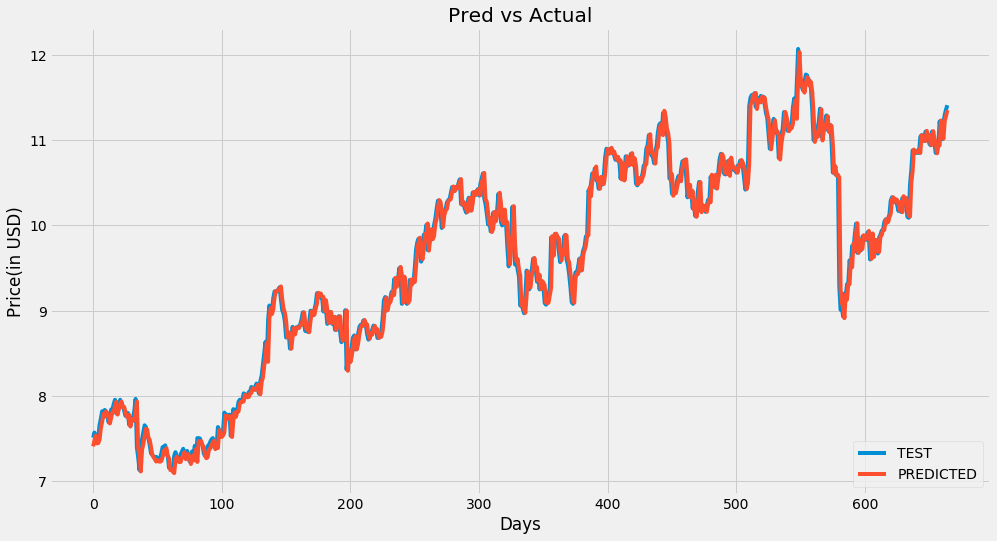

In [0]:
predicted = model.predict(test_x)

plt.figure(figsize=(15,8))
plt.plot(inverse_transform(test_y))
plt.plot(inverse_transform(predicted))
plt.xlabel('Days')
plt.ylabel('Price(in USD)')
plt.title('Pred vs Actual')
plt.legend(['TEST','PREDICTED'],loc='lower right')

In [247]:
model.save(f"models/{name}")
print(name)

STOCKPRED-1582435245


In [248]:
def predict_next_date():
  today = datetime.today().strftime('%d-%m-%y')
  df = web.DataReader('INFY',data_source='yahoo',start='20-02-2010', end=today)
  closing_data = df['Close']
  test_next = np.asarray(closing_data[-BUFFER:])
  test_next = transform(test_next)
  test_n = []
  test_n.append(test_next[0:BUFFER])
  test_n = np.asarray(test_n)
  test_n = np.reshape(test_n,(test_n.shape[0],test_n.shape[1],1))
  pred_n = model.predict(test_n)
  pred_inv = inverse_transform(pred_n)
  print(f'Next date\'s prediction: USD {pred_inv[0,0]}')

predict_next_date()

Next date's prediction: USD 11.399961709976196
